# OpenRouter + Prompt Caching

In [2]:
from openai import OpenAI
from os import getenv

# gets API Key from environment variable OPENAI_API_KEY
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=getenv("OPENROUTER_API_KEY"),
)

completion = client.chat.completions.create(
  model="meta-llama/llama-3.3-8b-instruct:free",  # https://openrouter.ai/meta-llama/llama-3.3-8b-instruct:free
  messages=[
    {
      "role": "user",
      "content": "Who are you?",
    },
  ],
)
print(completion.choices[0].message.content)


I'm an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."


# Using Langchain instead of API (Sinan's Recommendation)

In [3]:
from langchain_core.prompts import ChatPromptTemplate

template = ChatPromptTemplate([
    ("system", "You are a helpful AI bot. Your name is {name} and you answer questions."),
    ("human", "{question}"),
])

question = "What NFL team won the Super Bowl in the year Sinan Ozdemir was born?"


filled_in_prompt = template.invoke(
    {
        "name": "Kylie",
        "question": question
    }
)

/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
filled_in_prompt

ChatPromptValue(messages=[SystemMessage(content='You are a helpful AI bot. Your name is Kylie and you answer questions.', additional_kwargs={}, response_metadata={}), HumanMessage(content='What NFL team won the Super Bowl in the year Sinan Ozdemir was born?', additional_kwargs={}, response_metadata={})])

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
  openai_api_key=getenv("OPENROUTER_API_KEY"),
  openai_api_base="https://openrouter.ai/api/v1",
  model_name="meta-llama/llama-4-maverick"
)


ai_message = llm.invoke(filled_in_prompt)
ai_message

AIMessage(content='Sinan Ozdemir was born in 1990. Super Bowl XXIV took place on January 28, 1990. The San Francisco 49ers won the Super Bowl that year by defeating the Denver Broncos 55-10.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 50, 'total_tokens': 100, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-4-maverick', 'system_fingerprint': 'fp_565109a0df', 'id': 'gen-1757512282-pdi4sLuHBGU0Xfl6053s', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--6f32e5cb-8f71-49d4-88e6-9ec4b8166a26-0', usage_metadata={'input_tokens': 50, 'output_tokens': 50, 'total_tokens': 100, 'input_token_details': {}, 'output_token_details': {}})

In [6]:
import requests
import time
from os import getenv

def get_metadata_from_generation(ai_message, verbose=False, max_retries=10, retry_delay=1.0):
    """
    Get metadata from OpenRouter generation API with retry logic.
    
    Args:
        ai_message: The response from LangChain ChatOpenAI
        verbose: Whether to print detailed information
        max_retries: Maximum number of retry attempts (default: 10)
        retry_delay: Initial delay between retries in seconds (default: 1.0)
    
    Returns:
        dict: Generation metadata or None if failed
    """
    # Get the generation ID from the response
    generation_id = None
    if hasattr(ai_message, 'response_metadata'):
        generation_id = ai_message.response_metadata.get('id')
    
    if not generation_id:
        if verbose:
            print("No generation ID found in response metadata")
        return None
    
    headers = {
        'Authorization': f'Bearer {getenv("OPENROUTER_API_KEY")}'
    }
    
    # Retry logic with exponential backoff
    for attempt in range(max_retries):
        try:
            if verbose and attempt > 0:
                print(f"Retry attempt {attempt + 1}/{max_retries}")
            
            response = requests.get(
                f"https://openrouter.ai/api/v1/generation?id={generation_id}",
                headers=headers,
                timeout=30  # Add timeout to prevent hanging
            )
            
            if response.status_code == 200:
                gen_data = response.json()['data']
                if verbose:
                    print(f"✅ Successfully retrieved metadata on attempt {attempt + 1}")
                    print(f"Latency: {gen_data.get('latency', 'N/A')}s")
                    print(f"Provider: {gen_data.get('provider_name', 'N/A')}")
                    print(f"Total cost: ${gen_data.get('total_cost', 0)}")
                    print(f"Prompt tokens: {gen_data.get('tokens_prompt', 0)}")
                    print(f"Completion tokens: {gen_data.get('tokens_completion', 0)}")
                    print(f"Native prompt tokens: {gen_data.get('native_tokens_prompt', 0)}")
                    print(f"Native completion tokens: {gen_data.get('native_tokens_completion', 0)}")
                return gen_data
            
            elif response.status_code == 404:
                if verbose:
                    print(f"⏳ Generation {generation_id} not ready yet (attempt {attempt + 1}/{max_retries})")
            
            elif response.status_code == 429:
                if verbose:
                    print(f"⚠️ Rate limited (attempt {attempt + 1}/{max_retries})")
            
            else:
                if verbose:
                    print(f"❌ HTTP {response.status_code}: {response.text} (attempt {attempt + 1}/{max_retries})")
        
        except requests.exceptions.RequestException as e:
            if verbose:
                print(f"🔗 Network error: {e} (attempt {attempt + 1}/{max_retries})")
        
        except Exception as e:
            if verbose:
                print(f"💥 Unexpected error: {e} (attempt {attempt + 1}/{max_retries})")
        
        # Don't sleep after the last attempt
        if attempt < max_retries - 1:
            # Exponential backoff with jitter
            delay = retry_delay * (2 ** attempt) + (time.time() % 1)  # Add jitter
            if verbose:
                print(f"⏱️ Waiting {delay:.1f}s before retry...")
            time.sleep(delay)
    
    if verbose:
        print(f"❌ Failed to retrieve metadata after {max_retries} attempts")
    return None

metadata = get_metadata_from_generation(ai_message, verbose=True)
if metadata:
    print(f"Request cost: ${metadata['total_cost']}")
else:
    print("Could not retrieve cost information")

✅ Successfully retrieved metadata on attempt 1
Latency: 182s
Provider: Groq
Total cost: $1.6e-06
Prompt tokens: 45
Completion tokens: 49
Native prompt tokens: 50
Native completion tokens: 50
Request cost: $1.6e-06


In [7]:
ai_message.content

'Sinan Ozdemir was born in 1990. Super Bowl XXIV took place on January 28, 1990. The San Francisco 49ers won the Super Bowl that year by defeating the Denver Broncos 55-10.'

In [8]:
ai_message.response_metadata

{'token_usage': {'completion_tokens': 50,
  'prompt_tokens': 50,
  'total_tokens': 100,
  'completion_tokens_details': None,
  'prompt_tokens_details': None},
 'model_name': 'meta-llama/llama-4-maverick',
 'system_fingerprint': 'fp_565109a0df',
 'id': 'gen-1757512282-pdi4sLuHBGU0Xfl6053s',
 'service_tier': None,
 'finish_reason': 'stop',
 'logprobs': None}

In [9]:
ai_message.usage_metadata

{'input_tokens': 50,
 'output_tokens': 50,
 'total_tokens': 100,
 'input_token_details': {},
 'output_token_details': {}}

In [10]:
# add the AI message to the thread
filled_in_prompt.messages.append(ai_message)

In [11]:
from langchain_core.messages import HumanMessage
filled_in_prompt.messages.append(HumanMessage(content="and what's your name?"))


new_ai_message = llm.invoke(filled_in_prompt)
new_ai_message

AIMessage(content="My name is Kylie. I'm here to help you with any questions you have.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 109, 'total_tokens': 127, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/llama-4-maverick', 'system_fingerprint': 'fp_565109a0df', 'id': 'gen-1757512293-UW1B48R9iLslhqfKzgNh', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--2c9bee7e-b3c8-4529-992e-f0f3303830bf-0', usage_metadata={'input_tokens': 109, 'output_tokens': 18, 'total_tokens': 127, 'input_token_details': {}, 'output_token_details': {}})

In [12]:
new_ai_message.content

"My name is Kylie. I'm here to help you with any questions you have."

In [13]:
new_ai_message.response_metadata

{'token_usage': {'completion_tokens': 18,
  'prompt_tokens': 109,
  'total_tokens': 127,
  'completion_tokens_details': None,
  'prompt_tokens_details': None},
 'model_name': 'meta-llama/llama-4-maverick',
 'system_fingerprint': 'fp_565109a0df',
 'id': 'gen-1757512293-UW1B48R9iLslhqfKzgNh',
 'service_tier': None,
 'finish_reason': 'stop',
 'logprobs': None}

# Prompt Caching with OpenRouter + OpenAI

In [93]:
from datasets import load_dataset

# https://huggingface.co/datasets/mandarjoshi/trivia_qa is a big dataset, only grabbing the first 500!

ds_stream = load_dataset("mandarjoshi/trivia_qa", "rc", split="train", streaming=True)
first_500 = [x for _, x in zip(range(500), ds_stream)]


Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

In [115]:
all_wikis = [f['entity_pages']['wiki_context'][0] for f in first_500 if 'entity_pages' in f and len(f['entity_pages']['wiki_context'])]

In [116]:
import random
random_all_wikis = random.sample(all_wikis, 10)

In [117]:
len(all_wikis), len(random_all_wikis)

(392, 10)

In [153]:
# per documentation: "There is a minimum prompt size of 1024 tokens." for OpenAI
#  https://openrouter.ai/docs/features/prompt-caching

import time
template = ChatPromptTemplate([
    ("system", "You are a helpful AI bot and you answer questions. Here is some data to use {context}"),
    ("human", "{question}"),
])

results = []
for q_index, datapoint in enumerate(first_500[:10]):
    print(f"Question: {datapoint['question']}")
    for model in [
        "google/gemini-2.5-pro-preview",
        "openai/gpt-4.1-nano",
        "openai/gpt-4.1-mini",
        "openai/gpt-4.1"
    ]:
        
        llm_with_caching = ChatOpenAI(
          openai_api_key=getenv("OPENROUTER_API_KEY"),
          openai_api_base="https://openrouter.ai/api/v1",
          model_name=model
        )
        print(f'Model: {model}')
    
        filled_in_prompt = template.invoke(
            {
                "context": '\n'.join(random_all_wikis),
                "question": datapoint['question']
            }
        )
        time_before = time.time()
        ai_message = llm_with_caching.invoke(filled_in_prompt)
        time_after = time.time()
        metadata = get_metadata_from_generation(ai_message)
        if metadata:
            seconds = (time_after - time_before)
            metadata['total_seconds'] = seconds
            metadata['question_id'] = q_index
            results.append(metadata)
            token_usage = ai_message.response_metadata['token_usage']
            # print(f"Seconds: {seconds}. Total Tokens: {token_usage['total_tokens']}.  Cached Tokens: {token_usage['prompt_tokens_details']['cached_tokens']}")

Question: Which American-born Sinclair won the Nobel Prize for Literature in 1930?
Model: deepseek/deepseek-chat-v3-0324
Model: google/gemini-2.5-pro-preview
Question: Where in England was Dame Judi Dench born?
Model: deepseek/deepseek-chat-v3-0324
Model: google/gemini-2.5-pro-preview
Question: In which decade did Billboard magazine first publish and American hit chart?
Model: deepseek/deepseek-chat-v3-0324
Model: google/gemini-2.5-pro-preview
Question: From which country did Angola achieve independence in 1975?
Model: deepseek/deepseek-chat-v3-0324
Model: google/gemini-2.5-pro-preview
Question: Which city does David Soul come from?
Model: deepseek/deepseek-chat-v3-0324
Model: google/gemini-2.5-pro-preview
Question: Who won Super Bowl XX?
Model: deepseek/deepseek-chat-v3-0324
Model: google/gemini-2.5-pro-preview
Question: Which was the first European country to abolish capital punishment?
Model: deepseek/deepseek-chat-v3-0324
Model: google/gemini-2.5-pro-preview
Question: In which coun

In [154]:
import pandas as pd

df = pd.DataFrame(results)
df[['model', 'latency', 'generation_time', 'tokens_prompt', 'tokens_completion', 'origin', 'usage', 'total_cost', 'provider_name', 'total_seconds', 'question_id']].sample(3)

,model,latency,generation_time,tokens_prompt,tokens_completion,origin,usage,total_cost,provider_name,total_seconds,question_id
2,openai/gpt-4.1-2025-04-14,6712,193,66979,32,,0.132672,0.132672,OpenAI,7.458327,0
46,deepseek/deepseek-chat-v3-0324,924,454,66973,39,,0.019937,0.019937,DeepInfra,2.068527,8
7,openai/gpt-4.1-mini-2025-04-14,1493,167,66977,16,,0.006463,0.006463,OpenAI,5.163992,2


In [161]:
df[df['model'].str.contains('gem')]

,created_at,model,app_id,streamed,cancelled,latency,moderation_latency,generation_time,tokens_prompt,tokens_completion,...,finish_reason,native_finish_reason,usage,id,upstream_id,total_cost,cache_discount,provider_name,total_seconds,question_id
31,2025-06-04T21:16:35.420124+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,3690,NaN,12940,66979,482,...,stop,STOP,0.096735,gen-1749071781-lGGIBEpqEAxDmwHSSgT3,None,0.096735,NaN,Google AI Studio,14.024032,0
33,2025-06-04T21:17:12.245044+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,3469,NaN,6539,66974,205,...,stop,STOP,0.089637,gen-1749071824-P5LEOuTHGORIm4W90Ffr,None,0.089637,NaN,Google AI Studio,7.520552,1
35,2025-06-04T21:17:36.337911+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,2799,NaN,8351,66977,326,...,stop,STOP,0.028681,gen-1749071846-8NDOcLKAypFZPC1bZep9,None,0.028681,0.063505,Google AI Studio,9.159417,2
37,2025-06-04T21:18:13.147833+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,2805,NaN,21921,66976,812,...,stop,STOP,0.040651,gen-1749071870-gr94hBNQZdYlYJB5L3lR,None,0.040651,0.063505,Google AI Studio,22.235857,3
39,2025-06-04T21:18:28.261588+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,2718,NaN,3517,66972,164,...,stop,STOP,0.023992,gen-1749071904-h9caaF1oQror4CzQ5XuJ,None,0.023992,0.063505,Google AI Studio,4.008034,4
41,2025-06-04T21:18:43.78761+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,2936,NaN,5140,66970,159,...,stop,STOP,0.025613,gen-1749071918-7MaHslCK6G4iRiqgqP7U,None,0.025613,0.063505,Google AI Studio,5.584922,5
43,2025-06-04T21:19:16.420424+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,2261,NaN,7190,66976,259,...,stop,STOP,0.027648,gen-1749071948-5y4g8144ZETM4Q48oibO,None,0.027648,0.063505,Google AI Studio,7.536615,6
45,2025-06-04T21:19:46.384811+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,2334,NaN,4620,66980,169,...,stop,STOP,0.025499,gen-1749071981-JnpOhKekXTiUkneovBCL,None,0.025499,0.063505,Google AI Studio,4.899943,7
47,2025-06-04T21:19:56.206943+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,2332,NaN,4345,66973,125,...,stop,STOP,0.025300,gen-1749071991-B69hZ5A4u3QXeJJfgUkt,None,0.025300,0.063505,Google AI Studio,4.639724,8
49,2025-06-04T21:20:12.663133+00:00,google/gemini-2.5-pro-preview-03-25,None,True,False,2506,NaN,4475,66975,137,...,stop,STOP,0.024855,gen-1749072007-Lm4bGgxJ4qDN2hgJ8CPO,None,0.024855,0.063505,Google AI Studio,4.906046,9


In [155]:
# remove moderation to standardize

df['total_seconds'] = df['total_seconds'] - (df.fillna(0)['moderation_latency'] / 1000)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_12021/1242944438.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['total_seconds'] = df['total_seconds'] - (df.fillna(0)['moderation_latency'] / 1000)


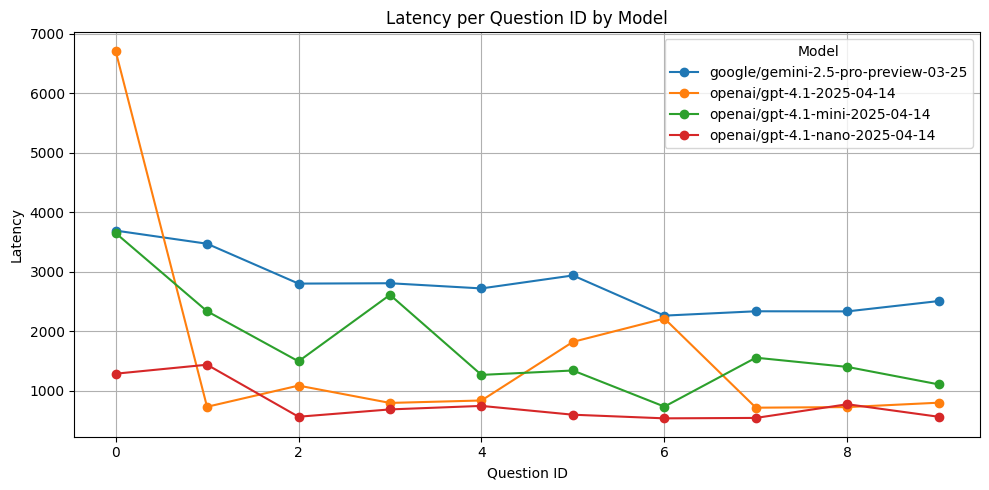

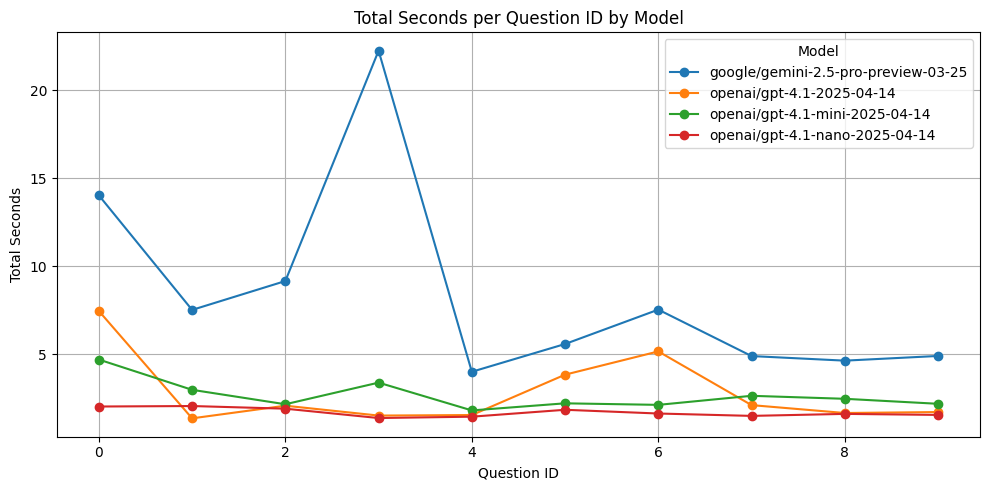

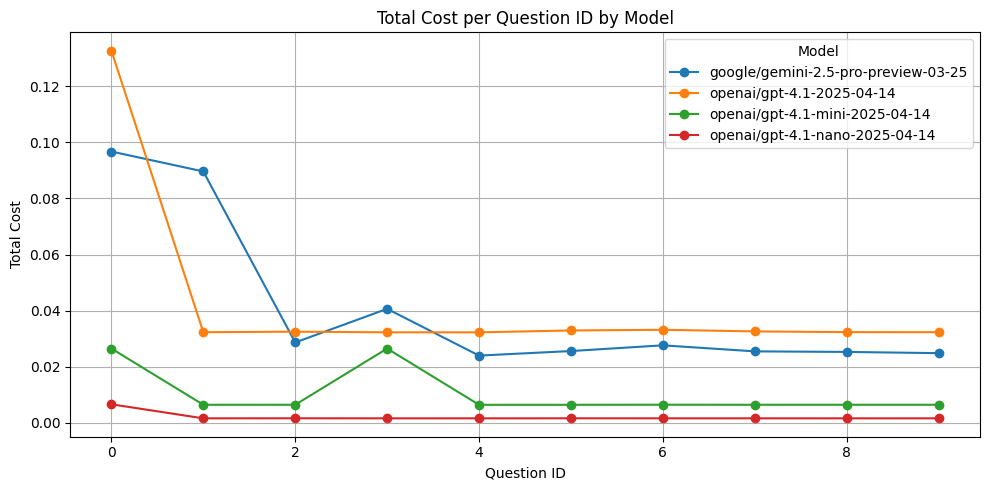

In [160]:
import matplotlib.pyplot as plt

# Plot for each metric
metrics = ['latency', 'total_seconds', 'total_cost']

# Sort the DataFrame by question_id before grouping
df_sorted = df.sort_values("question_id")

for metric in metrics:
    plt.figure(figsize=(10, 5))
    for model_name, group in df_sorted.groupby("model"):
        plt.plot(group["question_id"], group[metric], marker='o', label=model_name)
    plt.title(f"{metric.replace('_', ' ').title()} per Question ID by Model")
    plt.xlabel("Question ID")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend(title="Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
